In [2]:
# data wrangling
import re # regular expressions!

# math and data utilities
import numpy as np
import pandas as pd

# data and statistics libraries
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

# Initial Setup
We can download the data from Kaggle to our data folder using the command line:

`kaggle competitions download -c titanic`

`unzip titanic.zip`

After that, let's get the data into some Pandas dataframes:

In [3]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

## An outline of our process:

1. Exploratory Analysis: What variables are we working with. Which ones are categorical? Which ones are continuous? Are there missing values? Can we find any statistical relationships between our variables?

# Exploratory Data Analysis:

Our next step will be to ask and answer the following questions:

1. _Are we missing any data?_ 
2. _What form does our data take?_
3. _What additional information can we garner from what we already have?_
4. _What relationships can we find between our variables, especially between the input and output variables?_ 
5. _How can we use the answers to the first two question to add value to our data and the models that will use it?_


## Question 1: Missing Data
Let's take a look at the number of entries in our training data, as well as those variables contain significant missing data. Below, we see that the training data contains 891 passenger samples, with 11 total variables describing each passenger. We see that there is a significant amount of missing data for the variables __Age__ and __Cabin__. We will have to deal with this missing data by either finding an intelligent way to fill the gaps, or perhaps dropping the features entirely. 

In [4]:
# Question 1: Are we missing any data?
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Question 2: What is the form of our data:
Taking a look at our `.info()` print out as well as the first few entries of our data frame below, we see that our data comes primarily in the form of categorical data, with the exception of __Age__ and __Fare__. These categories are described by Python strings, which is why the data type above is listed as 'object'. This is how Pandas deals with unidentified data types. We will later tell Pandas that these variables are strings. 

In [5]:
# Look at the first few entries
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Question 3: What additional information can we garner from what we already have?

### Passenger Title
 
A quick glance at the __Name__ variable shows us that each name comes with a title. A title is useful in telling us things like social status, marriage status career, and even rank within a specific career. Therefore, it may be useful to have this information on hand. Let's parse it out:

In [6]:
train_df['Title'] = train_df['Name'].str.extract(r'([A-Za-z]+)\.')
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Sir           1
Ms            1
Lady          1
Don           1
Countess      1
Jonkheer      1
Mme           1
Name: Title, dtype: int64

Next, we might notice that many of these titles are synonymous. For example, _Mme_ is the French equivalent to  'Mrs' and _Mlle_ is the equivalent to  'Miss'. Other titles imply varying levels of nobility like 'Sir', 'Countess' and 'Don'. Some titles infer a profession. Let's reduce our titles to their common denominators:

In [7]:
title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Rev',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Dr', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

train_df.Title =train_df.Title.map(title_dict)

Text(0.5, 1.0, 'Histogram of Categorical Data: Title')

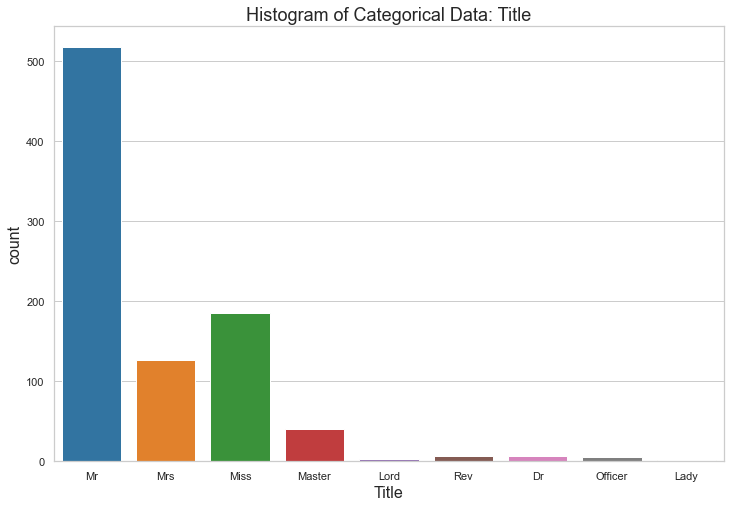

In [8]:
sns.countplot(train_df.Title).set_title("Histogram of Categorical Data: Title")

### Family Size

Lets look at a single entry of our data set for more clues that will help us gain new insight into our passengers:

In [9]:
train_df.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr


By again looking at our data set, we might notice the variables __SibSp__ and __Parch__. The first is the number of siblings and/or spouses that a passenger traveled with. The second is the number of parents and/or children a passenger traveled with. Combining these two variables we can get total family size. 

In [10]:
train_df['FamilySize'] = 1 + train_df.SibSp + train_df.Parch

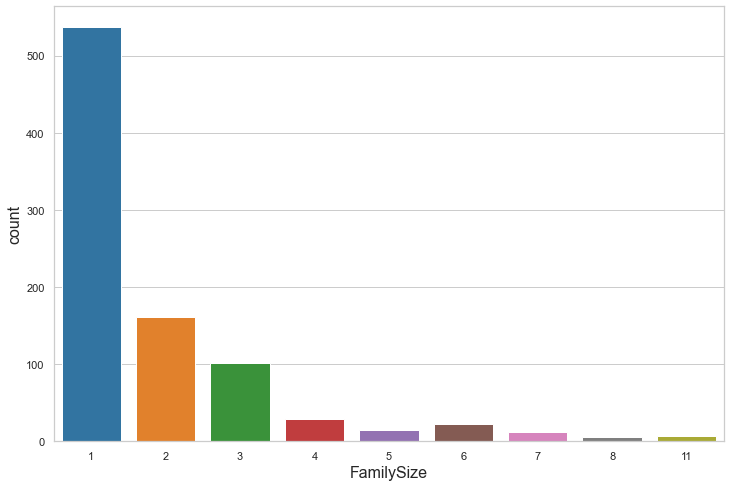

In [11]:
sns.countplot(train_df.FamilySize)

It appears that the Titanic's voyage was not necessarily a couple's or family affair. The majority of passengers traveled alone, and perhaps that is valuable information. Let's add the category __Alone__.

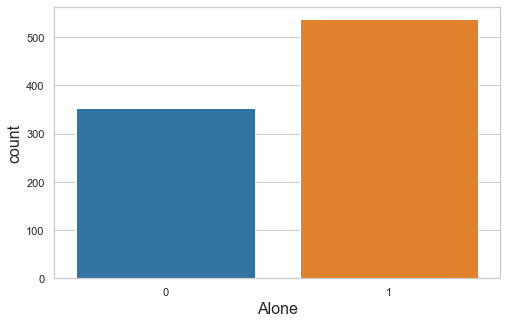

In [12]:
train_df['Alone'] = train_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
plt.figure(figsize=(8,5))
sns.countplot(train_df.Alone)

## Question 4: What statistical relationships does our data contain?

We now have a more robust data set that includes (possibly) valuable new insights into our passengers lives. But how helpful is this data, really? One way to find out is to look at the statistical relationships between our variables, especially between each input variable and our single output variable __Survived__. 

Correlation is a common go-to tool we would use to determine such relationships. However, it is important to note that we have mostly categorical data in our data set, and that throws a small wrench in our gears. 

First, our categorical data needs to be encoded into numeric format before we can do calculations of any kind. 

Next, we need to consider the number of categories that each variable falls into. 

For continuous variables and categorical variables that only contain two categories, using Pearson's correlation coefficient __($\rho$)__ is appropriate. For categorical data that contains more than 2 levels, it is more appropriate to use the correlation ratio __($\eta$)__. Let's separate out our features into these two categories and compute their correlation. 

In [13]:
train_df.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Alone
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,2,0


In [14]:
# continuous and categorical variables with 2 or less categories
cont_vars = ['Survived', 'Sex', 'Age', 'Fare', 'Alone']

# categorical variables with greater than 2 classes
cat_vars = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Title', 'FamilySize']

Next, we need to convert many of these variables from strings to numbers so that calculations can be performed.

In [15]:
# convert all string 'object' types to numeric categories
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        train_df[i], _ = pd.factorize(train_df[i])


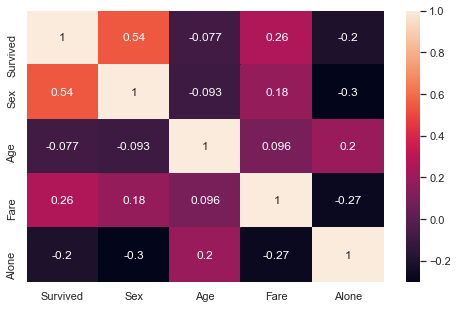

In [17]:
# Plot a correlation matrix of our now entirely numeric data:
plt.figure(figsize=(8, 5))
sns.heatmap(train_df[cont_vars].corr(), annot=True)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Alone
PassengerId,,,,,,,,,,,,,,
1,0,3,0,0,22.0,1,0,0,7.2500,-1,0,0,2,0
2,1,1,1,1,38.0,1,0,1,71.2833,0,1,1,2,0
3,1,3,2,1,26.0,0,0,2,7.9250,-1,0,2,1,1
4,1,1,3,1,35.0,1,0,3,53.1000,1,0,1,2,0
5,0,3,4,0,35.0,0,0,4,8.0500,-1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,886,0,27.0,0,0,677,13.0000,-1,0,5,1,1
888,1,1,887,1,19.0,0,0,678,30.0000,145,0,2,1,1
889,0,3,888,1,NaN,1,2,614,23.4500,-1,0,2,4,0
